# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import re

%matplotlib inline

# read in data and eliminate null columns
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# investigate shape of df
df.shape

(45993, 3)

In [3]:
# count the number of unique users (not including null values)
df['email'].nunique()

5148

In [4]:
# gather data about the integer article_ids
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [5]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [6]:
# investigate shape of the df_content dataframe
df_content.shape

(1056, 5)

In [7]:
# gather information about the article_id in the df_content dataframe
df_content.describe()

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
25%,260.750000
50%,523.500000
75%,786.250000
max,1050.000000


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [8]:
# group the df dataframe by user, then count how many articles interactions for each user
article_count = df.groupby('email').count()['article_id']
article_count.head()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
Name: article_id, dtype: int64

In [9]:
# gather summary statistics about total article interactions per user
article_count.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [10]:
# Fill in the median and maximum number of user_article interactios below
median_val = article_count.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = article_count.max() # The maximum number of user-article interactions by any 1 user is ______.

In [11]:
median_val

3.0

In [12]:
max_views_by_user

364

In [13]:
# find the email/id for the user with the most interactions
max_reader = article_count[article_count==max_views_by_user].index[0]

In [14]:
# investigate how many interactions that user has with each article
df[df['email']==max_reader].groupby('article_id').count()

,title,email
article_id,,
2.0,3,3
12.0,7,7
14.0,1,1
16.0,1,1
26.0,1,1
28.0,1,1
29.0,15,15
33.0,1,1
43.0,15,15


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [15]:
# Find and explore duplicate articles
df_content['article_id'].duplicated().sum()

5

In [16]:
# confirm df_content shape before removing duplicates
df_content.shape

(1056, 5)

In [17]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id',inplace=True)

In [18]:
# confirm duplicates were removed from df_content
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [19]:
# find the number of unique article_id values with interactions
df['article_id'].nunique()

714

In [20]:
# confirm the number of unique users by email
df['email'].nunique()

5148

In [21]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.shape[0] # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [22]:
# group the interactions by article and count total interactions per article
read_count = df.groupby('article_id').count().sort_values('email',ascending=False)['email']

In [23]:
read_count.head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [24]:
# find the max number of interactions with an article
read_count.max()

937

In [25]:
most_viewed_article_id = str(read_count.index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = read_count.max() # The most viewed article in the dataset was viewed how many times?

In [26]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    '''
    maps individual email identities to user_id numbers
    
    INPUT:
    None
    
    OUTPUT:
    None, but it does update the create a new user_id column in the dataframe and deletes the email column
    '''
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [27]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [28]:
# gathers the article_id for the top 'n' articles
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id').count().sort_values('user_id',ascending=False)['user_id']
    top_articles = list(top_articles.index[:n].astype(int))
    return top_articles # Return the top article ids

# finds the titles of the top 'n' articles
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_ids = get_top_article_ids(n)
    top_articles = list(df[df['article_id'].isin(article_ids)].drop_duplicates(subset='article_id')['title'])
    return top_articles # Return the top article titles from df (not df_content)

In [29]:
# display outputs of top 10 ids and titles
print(get_top_article_ids(10))
print(get_top_articles(10))

[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']


In [30]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [31]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = pd.pivot_table(df, values='title', index=['user_id'], columns=['article_id'], aggfunc=lambda x: int(len(x)>0), fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [32]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [33]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.loc[user_item.index != user_id,:].dot(user_item.loc[user_id,:])
    # sort by similarity
    similarity.sort_values(ascending=False, inplace=True)
    # create list of just the ids
    most_similar_users = list(similarity.index)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [35]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [36]:
def get_article_names(article_ids, df=df):
    '''
    gathers the names of the articles with given id numbers
    
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # gathers the names of articles for any article id that is included in the list of article ids
    article_names = list(df[df['article_id'].isin(article_ids)].drop_duplicates(subset='article_id')['title'])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''    
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # gathers all of the article ids with which the user has already interacted
    article_ids = list(user_item.columns[np.where(user_item.loc[user_id,:])].astype(str))
    # gets the article names for those same articles
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # create an empty set to store the recommendations
    recs = set()
    # gather the article ids for the previous articles from our target user
    user_articles = get_user_articles(user_id)[0]
    # identify all similar users, ranked from most similar
    similar_users = find_similar_users(user_id)
    # for each user in the similarity list
    for sim_user in similar_users:
        # gather the article ides for the previous articles for this particular similar user
        sim_user_articles = get_user_articles(sim_user)[0]
        # find the new articles that our target user had not read yet
        new_articles = np.setdiff1d(sim_user_articles, user_articles)
        # for each of the new items to recommend
        for item in new_articles:
            # if there are already enough recommendations
            if len(recs) >= m:
                # stop looking for more recommendations
                break
            # otherwise, if there are not enough recommendations yet
            else:
                # add the item to the set of recommendations
                recs.add(item)
        # at the end of a similar user, if there are enough recommendations, stop looking at other users
        if len(recs) >= m:
                break
        
    return list(recs) # return your recommendations for this user_id    

In [37]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [38]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [39]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    sorts users by similarity to target user and total activity so that collaborative filtering is as productive as possible
    
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create a matrix that measures similiarity
    sim_rating = pd.DataFrame(user_item.loc[user_item.index != user_id,:].dot(user_item.loc[user_id,:]), columns=['sim'])
    # count the total interactions for each user (measure of level of activity)
    interaction_count = pd.DataFrame(df.loc[df.user_id != user_id,:].groupby('user_id').count()['article_id'])
    # join the similarity ratings with the user interaction cout
    neighbors_df = sim_rating.join(interaction_count)  
    # rename the interaction count appropriately
    neighbors_df.rename(columns={'article_id':'interactions'}, inplace=True)
    # change the name of the index
    neighbors_df.index.name = 'neighbor_id'
    # sort the values by similarity and then by the number of user_interactions
    neighbors_df.sort_values(by=['sim','interactions'],ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # create an empty set for the recommendations
    recs = []
    # gather the 1000 most popular article ids for use ranking
    top_articles = df["article_id"].value_counts().index.tolist()
    # gets the articles already read by the target user
    user_articles = get_user_articles(user_id)[0]
    # gathers a list of users similar to the target user (sorted by similarity and level of activity)
    similar_users = get_top_sorted_users(user_id).index
    # go through each individual user
    for sim_user in similar_users:
        # get the similar user's articles
        sim_user_articles = get_user_articles(sim_user)[0]
        # gather only articles new to the target user
        new_articles = set(np.setdiff1d(sim_user_articles, user_articles))
        # create a list of the new articles
        new_list = [x for x in top_articles if str(float(x)) in new_articles]
        # keep adding articles to the recommendations until we reach the recommendation limit
        for item in new_list:
            if len(recs) >= m:
                break
            else:
                recs.append(float(item))
                user_articles.append(float(item))
        if len(recs) >= m:
                break
    
    # find all of the names of the articles
    rec_names  = get_article_names(recs)
    
    return recs, rec_names

In [40]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [41]:
### Tests with a dictionary of results
user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131

In [42]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Recommendations for a new user would behave just like a veteran user, but the similarity between the new user and all other users would be 0. This would default to pulling the most read articles from the most interactive users first. This would allow us to use `user_user_recs_part2` in the same way we use it for veteran users. The problem with this method is that the user does not exist yet, so the functions called by `user_user_recs_part2` will thrown an error until the user is officially introducted into the data and processed.**

**Alternatively, we could just pull the top articles using `get_top_articles` without any consideration for what the most interactive users are doing.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [43]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(float(x)) for x in get_top_article_ids(10)] # Your recommendations here

new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [44]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [45]:
def find_full_title(title, df_content=df_content):
    '''
    takes a title and then finds the complete title from the df_content dataframe
    
    INPUT:
    title - (string) the title of an article as it currently exists
    
    OUTPUT:
    true_title - returns the true title as identified in the df_content dataframe
    OR
    title - returns the title stripped of 3 or more leading digits and 4 spaces and trailing Name and dtype info
    
    '''
    
    # strip three of more leading digits followed by 4 spaces and remove trailing dataframe information
    title = re.sub("^[0-9]{3,}\s{4}","",title).replace('...\nName: title, dtype: object','')
    # look through every doc_full_name in the df_content dataframe
    for true_title in list(df_content['doc_full_name']):
        # make sure that all is lowercase for comparison purposes
        true_title = true_title.lower()
        # if the original title is in the true_title, but it is not already a direct match
        # exluding this week in data science, which has multiple matches
        if title in true_title and title != true_title and title != 'this week in data science':
            # return the full name of the article
            return true_title
    # otherwise, just return the title of the article
    return title

In [46]:
# correct article titles in the df dataframe
df['title'] = df['title'].apply(lambda x: find_full_title(x))

In [47]:
# calculate the estimated reading time for each article in the df_content dataframe (based on 250 words per minute)
df_content['est_time'] = df_content['doc_body'].apply(lambda x: int(round(len(str(x).split())/250.0,0)))

In [48]:
def make_content_recs(content_list,time_limit=30,k=10,df_content=df_content, df=df):
    '''
    a function that provides the most read articles that contain any key search terms or
    categories that a user may be interested in
    
    INPUT:
    content_list - (list) a list of strings including content to find (e.g. ['python', 'jupyter', 'spark'])
    time_limit - (int) the maximum approximate reading time for the article recommended articles (default: 10)
    k - (int) the maximum number of articles to recommend (default: 10)
    df - the dataframe of interactions between users and articles
    df_content - the dataframe of article information
    
    OUTPUT:
    recs - (list) a ranked list of the article titles according to the content areas specified in the search
    '''
    # create a list of the total interactions for each title as defined by the df dataframe
    title_interactions = df.groupby('title').count().sort_values(by='user_id', ascending=False)['user_id'].to_dict()
    # create an empty dictionary to store the recommendations and their previous interactions
    recs = {}
    # go through each content term for the user
    for content in content_list:
        # test if the term is in the doc_description or doc_full_name
        test = (df_content['doc_description'].apply(lambda x: content.lower() in str(x).lower()))
        test = test | (df_content['doc_full_name'].apply(lambda x: content.lower() in str(x).lower())) 
        # AND the article that has an estimated reading time less than or equal to the reading limit
        test = test & (df_content['est_time'] <= time_limit)
        # pull the titles that match the content area and reading limits
        titles = df_content[test]['doc_full_name']
        # for each matching title
        for title in titles:
            # if it has previous interactions from df dataframe
            if title.lower() in title_interactions.keys():
                # create a dictionary entry for that title with the amount of interactions
                recs[title.lower()] = title_interactions[title.lower()]
            # if the article is not found to have previous interactions
            else:
                # create a dictionary entry for that title with 0 interactions
                recs[title.lower()] = 0
    # rank the recommendations over all content areas by the number of interactions
    recs = dict(sorted(recs.items(), key=lambda item: item[1], reverse=True))
    # return the k top recommendations across all content areas
    return list(recs.keys())[:k]

In [49]:
make_content_recs(['watson','python'],time_limit=3,k=10)

['getting started with python',
 'using brunel in ipython/jupyter notebooks',
 'discover hidden facebook usage insights',
 'pixiedust 1.0 is here! – ibm watson data lab',
 'introducing streams designer',
 'analyzing streaming data from kafka topics',
 'jupyter notebooks with scala, python, or r kernels',
 'apple, ibm add machine learning to partnership with watson-core ml coupling',
 'excel files: loading from object storage — python',
 'variational auto-encoder for "frey faces" using keras']

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**The content-based recommendation function takes a list of keywords from the user, a reading time limit, and a number of articles. The system then find articles that have the keywords in their titles or descriptions and that meet the users reading time limit requirements and ranks them based on previous user interactions with the articles. The function then returns the appropriate number of the most popular articles that match the users keyword and reading time limit criteria.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [50]:
# make recommendations for a brand new user
# set content to "new user" default values
new_content = ['learn','tutorial','introduction']
make_content_recs(new_content, time_limit=10)

['deep learning with tensorflow course by big data university',
 'rapidly build machine learning flows with dsx',
 'the machine learning database',
 'tensorflow quick tips',
 'deep learning with data science experience',
 'building your first machine learning system ',
 'how to map usa rivers using ggplot2',
 'using machine learning to predict value of homes on airbnb',
 'machine learning exercises in python, part 1',
 'developing for the ibm streaming analytics service']

In [51]:
# make a recommendations for a user who only has interacted with article id '1427.0'
# set content to the words in the title of article 1427.0
content_1427 = df[df['article_id']==1427.0].head(1)['title'].values[0].split()
make_content_recs(content_1427)

['deep learning with tensorflow course by big data university',
 'jupyter notebook tutorial',
 'python machine learning: scikit-learn tutorial',
 'introducing ibm watson studio ',
 'working interactively with rstudio and notebooks in dsx',
 'rapidly build machine learning flows with dsx',
 'the pandas data analysis library',
 'the machine learning database',
 'learn tensorflow and deep learning together and now!',
 'real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [52]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [53]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the previous lesson.

In [54]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**This is different than the previous lesson because the previous lesson consisted of rating values (1-10) for each movie and maintained a null/nan value until that user had watched a particular movie. This produced richer data on which to calculate the weight of latent features and allowed us to take movies that the user had not watched and make predictions of how much the user would like an unseen movie by using FunkSVD.**

**In the context of the users and IBM articles, we just have binary values that track interaction between the articles and the users. The binary nature of this application fills in every cell with a value to represent the interaction with the article or lack thereof. This means there are no null/nan values on which to apply FunkSVD, so we cannot predict if or when a user may interact with an article in the future. The completeness of the table also means that the U, S, and Vt matrices are calculated to produce current read or unread states, so there is no way to apply them to predict future read/unread states.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

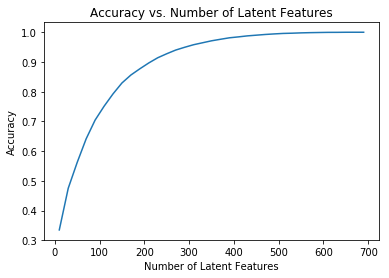

In [55]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [56]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = pd.pivot_table(df_train, values='title', index=['user_id'], columns=['article_id'], aggfunc=lambda x: int(len(x)>0), fill_value=0)
    user_item_test = pd.pivot_table(df_test, values='title', index=['user_id'], columns=['article_id'], aggfunc=lambda x: int(len(x)>0), fill_value=0)
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [57]:
len(set(user_item_test.index.values))

682

In [58]:
len(set(user_item_test.index.values) - set(user_item_train.index.values))

662

In [59]:
len(set(user_item_test.columns))

574

In [60]:
len(set(user_item_test.columns) - set(user_item_train.columns))

0

In [61]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [62]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [63]:
# create a subset of the items from the U matrix that are represented in the user_item_test matrix
u_test_subset = u_train[[x in test_idx for x in user_item_train.index.values],:]

In [64]:
# investigate size of the V transpose matrix
vt_train.shape

(714, 714)

In [65]:
# narrow the V transpose matrix to only those articles that are represented in the user_item_test matrix
vt_test_subset= vt_train[:,[x in test_arts for x in user_item_train.columns]]

In [66]:
# confirm the change in size
vt_test_subset.shape

(714, 574)

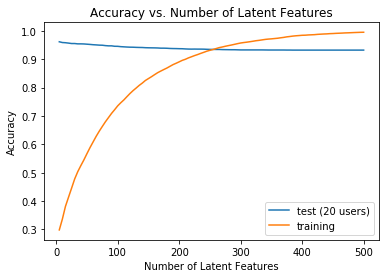

In [67]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(5,505,5)
sum_errs_test = []
sum_errs_train = []

for k in num_latent_feats:
    ### TESTING DATA
    # restructure with k latent features
    s_test, u_test, vt_test = np.diag(s_train[:k]), u_test_subset[:, :k], vt_test_subset[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_test, s_test), vt_test))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test[:20], user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs_test.append(err)
    
    ### TRAINING DATA
    # bring in the previous training data for comparison
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs_train.append(err)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df_test.shape[0]);
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df_train.shape[0]);
plt.legend(labels=['test (20 users)','training'])
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**In this context, there are several hundred articles that are NOT read by a user and only a few that are. There are no ratings, simply binary flags for the presence of an interaction between the user and the article. Singular Value Decomposition does not provide a great deal of insight in this case. In fact, SVD has a marginal decrease in its performance as more latent features are used in the prediction because those same latent features helped select those same articles as UNREAD by that particular user during training.**

**Due to the high number of unread articles in the dataset, accuracy is also a poor assessment of the strength of the model's performance. The graph shows a marginal decline in testing on the model because as more latent features are included in the model, the more likely the model is to predict an article as UNREAD (its training state), but our entire test set is likely NEW articles read by the users.**

**Due to the low number of predictable users (both in the training and testing set) and the problems with train and test splitting mentioned above, it is difficult to get a solid measure of accuracy.**

**Looking ahead, to measure the effectiveness of any of the recommendation systems above, I would implement a feedback system for users where they could score the utility of the article. This would allow the system to move away from a binary scoring system by developing user profiles (more complete preferences and predictions) in regards to what articles they find useful. This would improve the effect of the latent features in SVD and provide better user interaction metrics moving forward.**

**There could also be random sampling and feedback to allow users to inform the process - these could be formal surveys (which could provide feedback to all types of recommendations), or monitoring how often a user needs to change their search preferences to find an article before they interact with it (which would help improve content-based recommendations), or monitor user similarity over time to see if users become more of less similar based on our recommendations (which informs the collaborative filtering).**

**One way to implement, formalize, and measure how the methods above compare to the current system would be to implement a 60-day A/B experiment where the A group continues to find articles their usual way and the B group receives recommendations according to the algorithms above (collaborative filtering, content-based filtering). The two groups could then be compared according to a few metrics: time-spent on the site, number of interactions per month. Throughout this experiment, additional data could be collected regarding users preference for recommendation types, affinity with other users, etc. At the end of the 60-day experiment, depending on the results, the methods could be further adapted with the data gathered or rolled out to the entire community.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [68]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0